#### CIFAR10 Attack Notebook

In [1]:
%%capture installation
import os
import sys
import argparse
import datetime

import numpy as np

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [50]:
class Args:
    batch_size = 1
    attack_name = "deepfool"
    device  = "mps"
    model_name = "mnist_ann_1"
    ae_name = "cc_ann_100"
    plot = False
    plot_dir = "./plots"
    # kwargs = {"norm": "inf", "eps": 0.1} # fgsm
    # kwargs = {"eps": 0.8, "eps_step": 0.1, "max_iter": 100} # bim
    kwargs = {} # deepfool

args = Args()

In [51]:
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")
_, _, test_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader {config['dataset_name']}!!!!!") 

Working on the dataset: mnist!!!!!
Loaded classifier and autoencoder models in eval mode!!!!!
Loaded dataloader mnist!!!!!


In [52]:
x, y, z = get_xyz(args, autoencoder_model, test_dataloader)
    
config["latent_shape"] = args.ae_name.split('_')[-1]
classifier, hybrid_classifier, accuracy = hybridize(x, y, z, 
                                                    config, classifier_model, autoencoder_model)

# Perform attack
result: Dict = execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model, args.kwargs)

Accuracy on benign test examples: 100.0%
Accuracy on benign test examples(from reconstructed): 100.0%


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Accuracy on adversarial test examples: 0.0%


DeepFool: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]

Accuracy on adversarial test examples(Reconstruced X_adv): 0.0%
Accuracy on adversarial test examples(Modified): 100.0%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 1, 28, 28])
torch.Size([3, 32, 152])


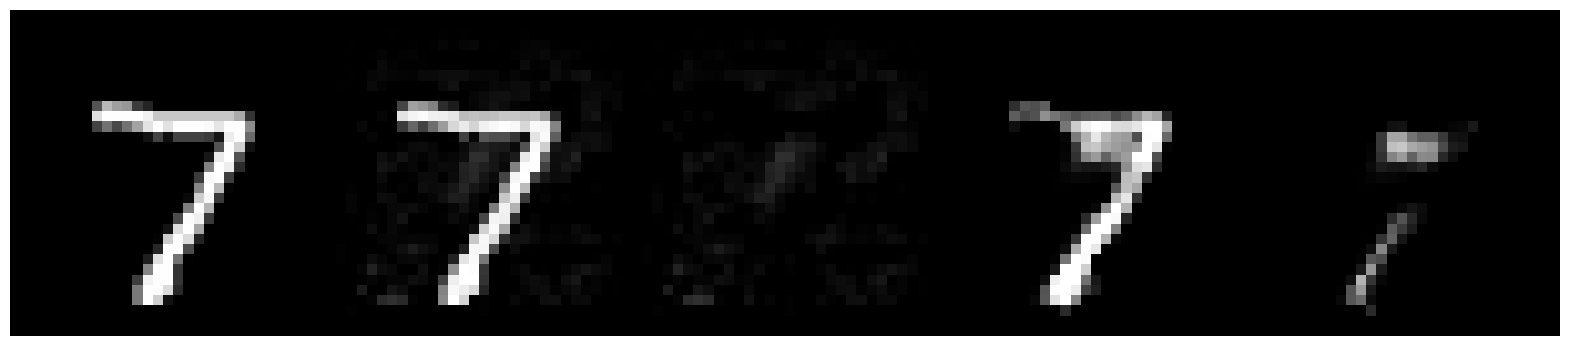

In [53]:
orig_attk_images = result[attack_name.__name__]["x_test_adv_np"]
modf_attk_images = result[attack_name.__name__]["xx_test_adv_np"]
recon_attk_images = result[attack_name.__name__]["x_hat_adv_accuracy"]

orig_attk_noise = result[attack_name.__name__]["x_test_noise"]
modf_attk_noise = result[attack_name.__name__]["xx_test_noise"]
# hybrid_attk_noise = result[attack_name.__name__]["hybrid_noise"]

all_images = np.concatenate((x[1], orig_attk_images, orig_attk_noise, modf_attk_images, modf_attk_noise), 0)

import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 10))
    images = torch.Tensor(images).reshape(-1, 1, 28, 28)
    print(images.shape)
    # i = 1
    # for image in images:
    #     plt.subplot(5, 5, i, xticks=[], yticks=[])
    #     plt.imshow(np.transpose(image, (1, 2, 0)))
    #     i = i + 1

    #     if i == 26:
    #         break
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=False, range=(-1,1))
    print(grid.shape)
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
plot_images(all_images)

##### Visualising Latent Code

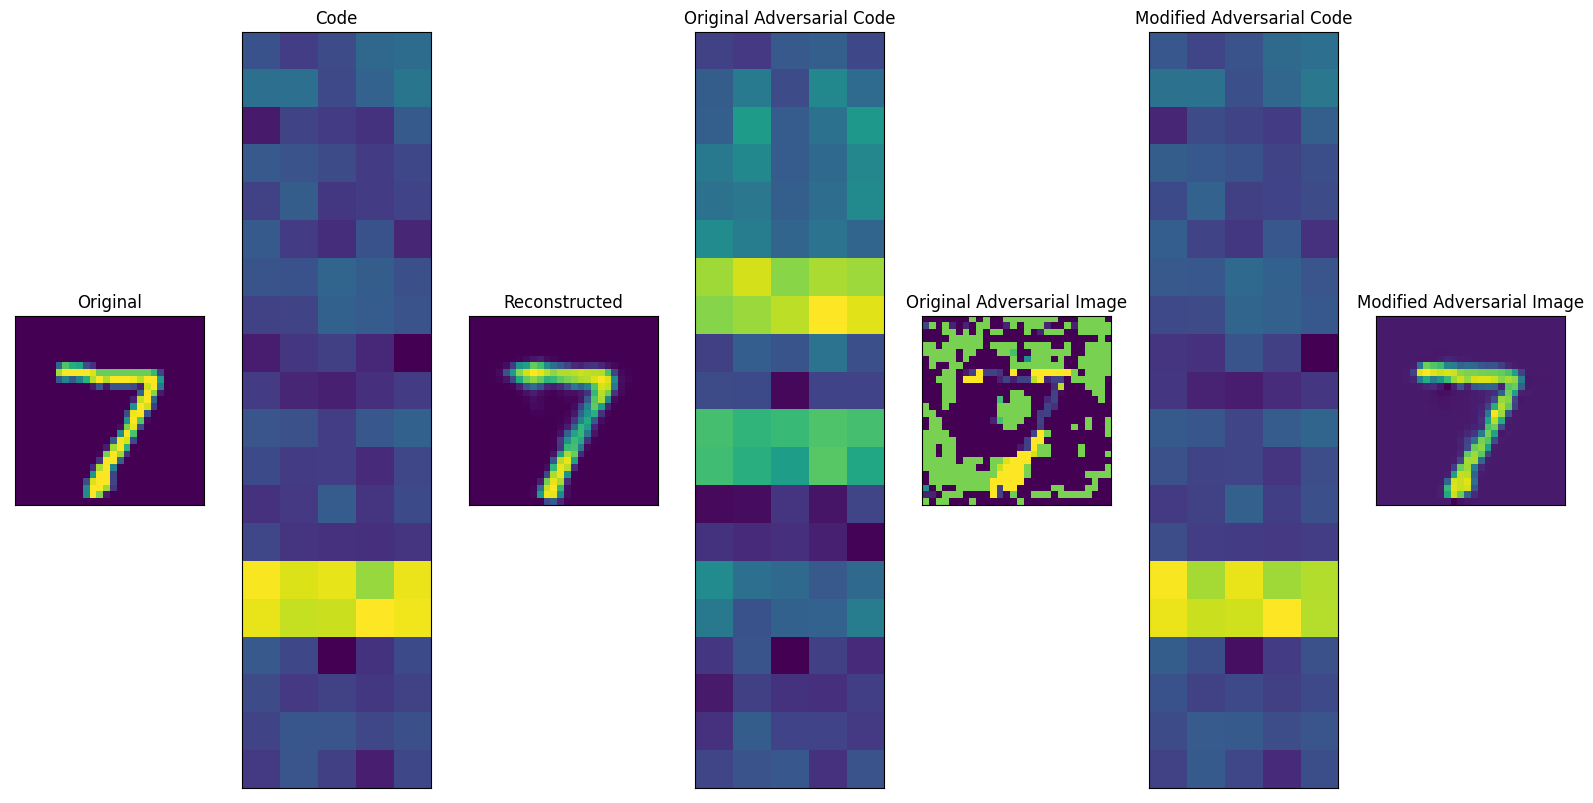

In [46]:
import torch
import matplotlib.pyplot as plt

def plot_recons_with_latent_codes(x, z, x_hat, z_adv, x_adv, zz_adv, xx_adv):
    plt.figure(figsize=(20, 10))
    plt.subplot(1,7,1, xticks=[], yticks=[])
    plt.title("Original")
    plt.imshow(x.reshape((28, 28)))

    plt.subplot(1,7,2, xticks=[], yticks=[])
    plt.title("Code")
    plt.imshow(z.reshape([z.shape[-1]//5,-1]).cpu().detach().numpy())

    plt.subplot(1,7,3, xticks=[], yticks=[])
    plt.title("Reconstructed")
    plt.imshow(x_hat.reshape((28, 28)))

    plt.subplot(1,7,4, xticks=[], yticks=[])
    plt.title("Original Adversarial Code")
    plt.imshow(z_adv.reshape([z.shape[-1]//5,-1]))

    plt.subplot(1,7,5, xticks=[], yticks=[])
    plt.title("Original Adversarial Image")
    plt.imshow(x_adv.reshape((28, 28)))

    plt.subplot(1,7,6, xticks=[], yticks=[])
    plt.title("Modified Adversarial Code")
    plt.imshow(zz_adv.reshape([z.shape[-1]//5,-1]))

    plt.subplot(1,7,7, xticks=[], yticks=[])
    plt.title("Modified Adversarial Image")
    plt.imshow(xx_adv.reshape((28, 28)))
    plt.show()

autoencoder_model = autoencoder_model.to(args.device)
x_hat, z, preds = autoencoder_model(x[0].to(args.device))
x_hat = x_hat.cpu().detach().numpy()

x_adv = torch.Tensor(result[attack_name.__name__]["x_test_adv_np"])
_, z_adv, preds = autoencoder_model(x_adv.to(args.device))
z_adv = z_adv.cpu().detach().numpy()

zz_adv = result[attack_name.__name__]["z_test_adv_np"]
xx_adv = result[attack_name.__name__]["xx_test_adv_np"]
plot_recons_with_latent_codes(x[1], z, x_hat, z_adv, x_adv, zz_adv, xx_adv)

##### LPIPS

In [119]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
import torchvision.transforms.functional as fn

img0 = fn.resize(torch.Tensor(orig_attk_images).reshape(-1, 1, 28, 28).tile((1, 3, 1, 1)), [32]) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = fn.resize(x[0].detach().cpu().reshape(-1, 1, 28, 28).tile((1, 3, 1, 1)), [32])

d = loss_fn_alex(img0, img1)
print(d.flatten())

img0 = fn.resize(torch.Tensor(modf_attk_images).reshape(-1, 1, 28, 28).tile((1, 3, 1, 1)), [32]) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = fn.resize(x[0].detach().cpu().reshape(-1, 1, 28, 28).tile((1, 3, 1, 1)), [32])

d = loss_fn_alex(img0, img1)
print(d.flatten())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
tensor([0.2396, 0.1845, 0.4810, 0.2265, 0.2968, 0.4007, 0.1918, 0.1974, 0.1212,
        0.2061], grad_fn=<ReshapeAliasBackward0>)
tensor([0.0299, 0.0107, 0.1301, 0.0160, 0.0371, 0.0672, 0.0231, 0.0148, 0.0097,
        0.0324], grad_fn=<ReshapeAliasBackward0>)
